# Web Scraping BoxOfficeMojo with BeautifulSoup.

**The goal** of this notebook is to produce a dataframe with the information about movies from [Box Office Mojo](https://www.boxofficemojo.com). The dataset obtained from webscraping will be used for exploratory data analysis, linear regression modeling and feature engineering. The resulting dataframe will be saved in the csv format for easier access in the future, as well as in movies.py python file, located in the same repository, for future projects.

**The code** executed below will **result** in extracting data about domestic movies from 2019 (roughly 800 or so), and will provide us with some insights, such as movie title, total domestic gross revenue, runtime, rating, and budget.

#### Tools and Libraries

In [72]:
from bs4 import BeautifulSoup
import requests
import time, os
import dateutil.parser
import numpy as np
import pandas as pd
import re
import seaborn as sns 
import matplotlib.pyplot as plt

from urllib.parse import urljoin

#### URL details for the request

In [73]:
extension_url = '/year/2019/?ref_=bo_yl_table_1'
base_url = 'https://www.boxofficemojo.com' 
url = base_url + extension_url

In [74]:
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')
table = soup.find_all('table')
df = pd.read_html(str(table))[0]
df.drop(columns=['Genre', 'Budget', 'Running Time'], inplace=True)

#### Helper functions: $ --> integer, hours + min --> min, date --> datestring

In [75]:
def money_to_int(moneystring):
    if type(moneystring) != float:
        moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    if runtimestring != None:
        runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

#### Helper function: findNext( ) to find sibling object values.

In [76]:
def get_movie_value(soup, field_name):
    
    '''Grab a value from Box Office Mojo HTML
    
    Takes a string attribute of a movie on the page and returns the string in
    the next sibling object (the value for that attribute) or None if nothing is found.
    '''
    
    obj = soup.find(text=re.compile(field_name))
    
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    
    if next_element:
        return next_element.text 
    else:
        return None

#### Helper function: extracts movie stats, such as title, money, rating etc. and puts them into a dictionary.

Removal of *release_date* clause in the function below was necessary. It was creating the bug that I couldn't identify quickly enough, and I had to proceed. I will sacrifice the date a movie was released for the sake of this particular exercise.

In [77]:
def get_movie_dict(link):
    '''
    From BoxOfficeMojo link stub, request movie html, parse with BeautifulSoup, and
    collect 
        - title 
        - domestic gross
        - runtime 
        - MPAA rating
        - full release date
    Return information as a dictionary.
    '''
    
    base_url = 'https://www.boxofficemojo.com'
    
    #Create full url to scrape
    url = urljoin(base_url, link)
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")


    headers = ['movie_title', 'domestic_total_gross',
               'runtime_minutes', 'rating', 'budget']

    #Get title
    title_string = soup.find('title').text
    title = title_string.split('-')[0].strip()

    #Get domestic gross
    try:
        raw_domestic_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    except:
        raw_domestic_total_gross = float("NaN")

    if type(raw_domestic_total_gross) == float or type(raw_domestic_total_gross) == 'NoneType':
        print('This is NaN')
        domestic_total_gross = float("NaN")
    else:
        domestic_total_gross = money_to_int(raw_domestic_total_gross)

    #Get runtime
    raw_runtime = get_movie_value(soup,'Running')
    if type(raw_runtime) != float and type(raw_runtime) != 'NoneType':
        runtime = runtime_to_minutes(raw_runtime)

    #Get rating
    rating = get_movie_value(soup,'MPAA')

#     I had to take out thios part, because it was creating the bug in the code, 
#.    so I couldn't pull enough values until I took this block out.

#     #Get release date
#     if '-' in get_movie_value(soup, 'Release Date'):
#         raw_release_date = get_movie_value(soup,'Release Date').split('-')[0]
#     elif '(' in get_movie_value(soup, 'Release Date'):
#         raw_release_date = get_movie_value(soup,'Release Date').split('(')[0]
#     else:
#         raw_release_date = get_movie_value(soup,'Release Date').split('(')[0]
#     release_date = to_date(raw_release_date)



    # Get budget alt
    raw_budget = get_movie_value(soup,'Budget')
    if raw_budget:
        budget = money_to_int(raw_budget)
    else:
        budget = 0

    #Create movie dictionary and return
    movie_dict = dict(zip(headers,[title,
                                domestic_total_gross,
                                runtime,
                                rating,
                                
                                budget]))

    return movie_dict


###### Now, we create expressions to sort through the html soup.

In [78]:
table = soup.find('table')
rows = [row for row in table.find_all('tr')]

It seems like we are looking for the values attached to the "href" attribute, as is seems to be holding the extension to our base url. We use those extension links to access each individual movie in order to extract data.

In [79]:
rows[1].find_all('td')[1].find('a')

<a class="a-link-normal" href="/release/rl3059975681/?ref_=bo_yld_table_1">Avengers: Endgame</a>

In [80]:
rows[1].find_all('td')[1].find('a')['href']

'/release/rl3059975681/?ref_=bo_yld_table_1'

We slice the url extension that we found via the path shown above, and we manually set up the beginning and the end of the string that we are interested in. For instance, to extract the value of *rl3059975681* from the text *'/release/rl3059975681/?ref_=bo_yld_table_1'* that was returned in the cell above, we create variable called *section*. This variable will hold the extension of the movie link. Then we crop it by defining the *beginning* and the *end* of the string, and use it to slice the *section* thus defining the *substring*. We save those movie stubs into the *mojo_links* list. I've been told it works faster with Selenium, but I chose to focus on [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) instead. 

In [84]:
mojo_links = []
for i in range(1,800):
    section = rows[i].find('a')['href']
    start = section.find("release/") + len("release/")
    end = section.find("/?ref_")
    substring = section[start:end]
    mojo_links.append(substring)
mojo_links

['rl3059975681',
 'rl3321923073',
 'rl3798500865',
 'rl2424210945',
 'rl3009644033',
 'rl3305145857',
 'rl3791750657',
 'rl3246360065',
 'rl252151297',
 'rl1107461633',
 'rl755467777',
 'rl1711506945',
 'rl2919400961',
 'rl1476560385',
 'rl2606269953',
 'rl1719436801',
 'rl17139201',
 'rl520455681',
 'rl1196197377',
 'rl3108800001',
 'rl3204875777',
 'rl2675869185',
 'rl939755009',
 'rl1518241281',
 'rl2991883777',
 'rl3204679169',
 'rl990348801',
 'rl1517848065',
 'rl3255404033',
 'rl101025281',
 'rl2399634945',
 'rl4261709313',
 'rl1887340033',
 'rl1275299329',
 'rl879986177',
 'rl2986509825',
 'rl939820545',
 'rl1392805377',
 'rl2885912065',
 'rl201819649',
 'rl1745257985',
 'rl2852554241',
 'rl3263137281',
 'rl4211181057',
 'rl3103950337',
 'rl4144072193',
 'rl3993339393',
 'rl2852423169',
 'rl2651096577',
 'rl2634515969',
 'rl2139063809',
 'rl402884097',
 'rl0361985',
 'rl3221390849',
 'rl805799425',
 'rl1560446465',
 'rl436438529',
 'rl4228089345',
 'rl1443202561',
 'rl3825501697

###### Now, we append those movie link stubs into a dictionary, using our helper function get_movie_dict() from above.

**Warning:** The cell below takes long time to run. I saved its output in the *return_titles()* function, located in *movies.py* module. It's also available as a text file called *scraping output*. All are located in the same repository. **Run at your own risk.**

In [85]:
dicts = []

for link in mojo_links:
    dicts.append(get_movie_dict('/release/{}/'.format(link)))

dicts

[{'movie_title': 'Avengers: Endgame',
  'domestic_total_gross': 858373000,
  'runtime_minutes': 181,
  'rating': 'PG-13',
  'budget': 356000000},
 {'movie_title': 'The Lion King',
  'domestic_total_gross': 543638043,
  'runtime_minutes': 118,
  'rating': 'PG',
  'budget': 260000000},
 {'movie_title': 'Toy Story 4',
  'domestic_total_gross': 434038008,
  'runtime_minutes': 100,
  'rating': 'G',
  'budget': 200000000},
 {'movie_title': 'Frozen II',
  'domestic_total_gross': 477373578,
  'runtime_minutes': 103,
  'rating': 'PG',
  'budget': 150000000},
 {'movie_title': 'Captain Marvel',
  'domestic_total_gross': 426829839,
  'runtime_minutes': 123,
  'rating': 'PG-13',
  'budget': 160000000},
 {'movie_title': 'Star Wars: Episode IX',
  'domestic_total_gross': 515202542,
  'runtime_minutes': 142,
  'rating': 'PG-13',
  'budget': 275000000},
 {'movie_title': 'Spider',
  'domestic_total_gross': 390532085,
  'runtime_minutes': 129,
  'rating': 'PG-13',
  'budget': 160000000},
 {'movie_title':

###### Finally, we are saving this dictionary into a Pandas DataFrame and eventually a csv file for faster data analysis available to you in the next notebook.

In [86]:
movie_df = pd.DataFrame(dicts)

In [87]:
movie_df.head()

,movie_title,domestic_total_gross,runtime_minutes,rating,budget
0,Avengers: Endgame,858373000,181.0,PG-13,356000000
1,The Lion King,543638043,118.0,PG,260000000
2,Toy Story 4,434038008,100.0,G,200000000
3,Frozen II,477373578,103.0,PG,150000000
4,Captain Marvel,426829839,123.0,PG-13,160000000


In [89]:
movie_df.to_csv('box_office_mojo_data.csv')

The code above saved our *movie_df* dataframe into a csv in the working directory on my computer. It looks like this:
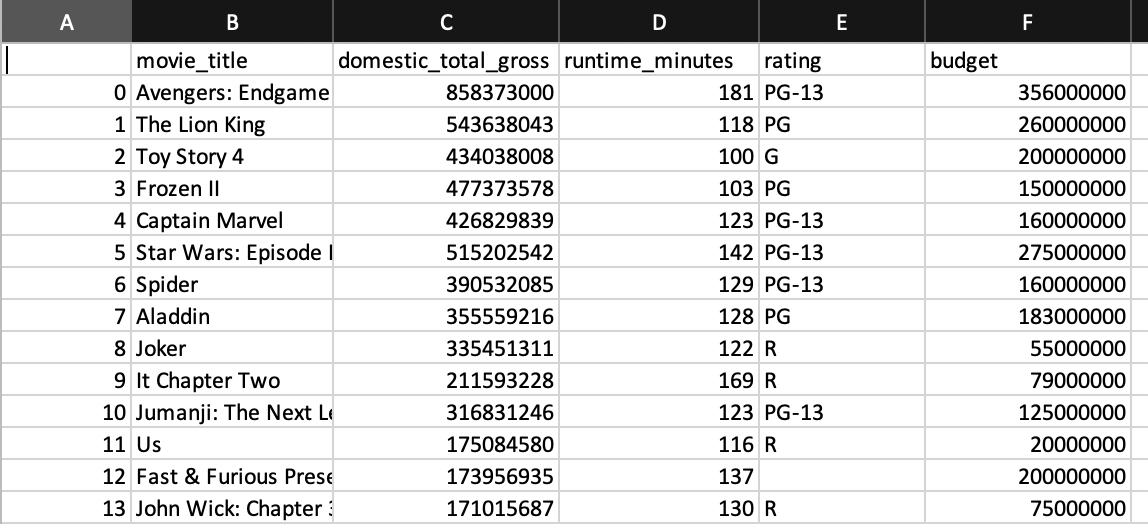

**Now, off to the EDA!**